# Case Study: Sentiment Analysis on the IMDB Dataset with TensorFlow and Keras

## Objective

This case study provides a comprehensive walkthrough of sentiment analysis on the IMDB dataset. It starts with exploratory data analysis (EDA) to understand the data, then moves on to preprocessing, feature engineering, model building, and evaluation. Various neural network architectures will be implemented, TensorBoard will be used for tracking model metrics, and transformers from Hugging Face will be explored for leveraging pretrained models. The goal is to turn theory into practice and gain a solid grasp of the full sentiment analysis workflow.

### Why Sentiment Analysis?

Sentiment analysis helps in interpreting text data, allowing machines to categorize content based on emotions or opinions. It's widely used in industries like marketing, customer service, and social media analysis. This case study will focus on binary sentiment classification (positive vs. negative) using movie reviews from IMDB.



## Dataset Overview

The IMDB dataset contains movie reviews, each tagged as either positive or negative. It is a popular choice for sentiment analysis, where the goal is to determine the overall sentiment expressed in a piece of text. This dataset is ideal for learning the fundamentals of text classification, feature extraction, and training machine learning models for natural language processing (NLP).

The dataset includes:
- 25,000 movie reviews for training
- 25,000 movie reviews for testing
- Reviews are already tokenized (each review is represented as a sequence of integers, where each integer corresponds to a word in a dictionary)
- Binary sentiment labels: A sentiment of 1 for a positive review and 0 for a negative review

The IMDB dataset is balanced, with an approximately equal number of positive and negative reviews.

### Why IMDB Dataset?

- **Real-World Application:** Sentiment analysis of product reviews, customer feedback, or social media posts can be done similarly to this case study, making this dataset highly relevant to real-world applications.

- **Simplicity and Accessibility:** The IMDB dataset is pre-processed and easily accessible via Keras, which makes it ideal for students who are learning how to apply neural networks to text data.

## Exploratory Data Analysis (EDA)

### Step 1: Importing Libraries and Dataset

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Load IMDB dataset (keeping only the top 10,000 most frequent words)
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

print(train_data.shape)

(25000,)


In [14]:
# Display a sample review

# Get mapping of words to integer indices
word_index = imdb.get_word_index()

# Reverse mapping: integer indices to words
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Decode the first training review from integers back to words
# Note: indices 0, 1, 2 are reserved, so subtract 3 to get the correct word
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

# Display the decoded review and its label (0 = negative, 1 = positive)
print("Sample Review:", decoded_review)
print("Label (0 = negative, 1 = positive):", train_labels[0])

Sample Review: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have don

- We began by exploring the IMDB dataset to see its structure and contents. The dataset contains movie reviews labeled as positive or negative, with the vocabulary restricted to the 10,000 most frequent words. We then converted a tokenized review back into text to check the data format and confirm how the labels are assigned, setting the stage for sentiment analysis.

### Step 2: Exploring Review Lengths


Understanding the variation in review lengths can help decide on padding and truncation strategies during preprocessing.

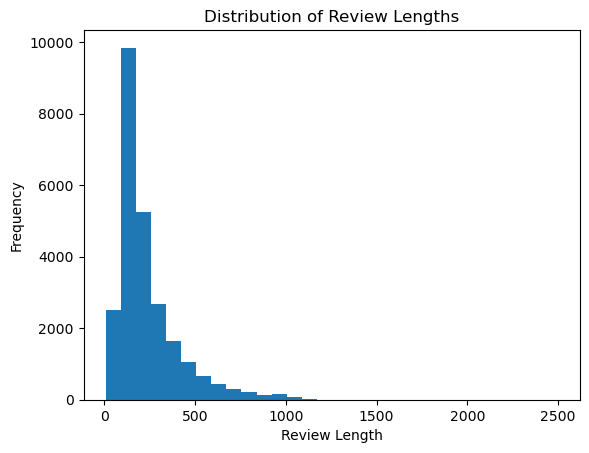

In [15]:
import matplotlib.pyplot as plt

review_lengths = [len(review) for review in train_data]
plt.hist(review_lengths, bins=30)
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

- We examined the length of each review in the IMDB dataset by counting its words (tokens) and plotted the results as a histogram. Most reviews are short, but a few are much longer, creating a long right tail. This variation matters when preprocessing, as it guides decisions on padding or truncating reviews to a fixed length for model input.

### Step 3: Class Distribution

Checking the balance of positive and negative labels is essential for choosing appropriate evaluation metrics.

In [16]:
import numpy as np

# Count positive reviews (labels are 1 for positive, 0 for negative)
positive_reviews = np.sum(train_labels)
negative_reviews = len(train_labels) - positive_reviews
print("Positive reviews:", positive_reviews)
print("Negative reviews:", negative_reviews)

Positive reviews: 12500
Negative reviews: 12500


We counted how many reviews in the training set are positive (1) and how many are negative (0). This gives us a quick view of the class distribution, helping check if the dataset is balanced — an important factor for model evaluation and avoiding bias.

## Preprocessing

To train a neural network, inputs must be in numeric form. The IMDB dataset already provides tokenized reviews as integer sequences, so here we only perform padding to make their lengths consistent.



### Step1: Tokenization and Word Embeddings


- Tokenization: Each word is converted into a unique integer.
- Padding and Truncation: To ensure reviews are of equal length, we pad shorter ones and truncate longer ones.

In [17]:
# Tokenization and Padding

# Pad/truncate all reviews so they have the same length (256 tokens)
# - Shorter reviews: padded with zeros at the end
# - Longer reviews: truncated to 256 tokens
train_data = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=256, padding='post')
test_data = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=256, padding='post')
# Check the shape of the padded data
print("Padded train data shape:", train_data.shape)

Padded train data shape: (25000, 256)


We tokenized the IMDB reviews and used Keras’ pad_sequences to make all reviews the same length. Each review was padded or truncated to 256 words (maxlen=256), with extra padding added at the end (padding='post'). This step standardizes the input length across all reviews, making it suitable for training a neural network model that requires fixed-length inputs.

## Model Building and Training

A neural network consists of layers of neurons that process input data. In this model, we’ll use:

- Embedding Layer: Turns words into dense vectors.
- GlobalAveragePooling1D: Summarizes embeddings, reducing complexity.
- Dense Layers: Fully connected layers for classification.

In [18]:
# Simple Neural Network Model
model = keras.Sequential([
    # Embedding layer: maps word indices (0–9999) to 16-dim vectors
    keras.layers.Embedding(input_dim=10000, output_dim=16),

    # Reduce sequence of word vectors into a single fixed-size vector by averaging
    keras.layers.GlobalAveragePooling1D(),

    # Hidden dense layer with ReLU activation
    keras.layers.Dense(16, activation="relu"),

    # Output layer with sigmoid activation - probability of positive sentiment
    keras.layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train the model
history = model.fit(train_data, train_labels, epochs=10,
                    validation_data=(test_data, test_labels))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7072 - loss: 0.5747 - val_accuracy: 0.8191 - val_loss: 0.4141
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8678 - loss: 0.3271 - val_accuracy: 0.8659 - val_loss: 0.3197
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8934 - loss: 0.2655 - val_accuracy: 0.8743 - val_loss: 0.2971
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9114 - loss: 0.2291 - val_accuracy: 0.8746 - val_loss: 0.2974
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9235 - loss: 0.2034 - val_accuracy: 0.8785 - val_loss: 0.2911
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9294 - loss: 0.1871 - val_accuracy: 0.8714 - val_loss: 0.3111
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9372 - loss: 0.1708 - val_accuracy: 0.8821 - val_loss: 0.2912
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9400 - loss: 0.1601 - val_accuracy: 0.

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 256, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,869 (1.83 MB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,580 (1.22 MB)

- Here, we built a simple neural network model for sentiment analysis on the IMDB dataset. The model consists of the following layers:
 - **Embedding Layer**: This layer transforms the input data (word indices) into dense vectors of fixed size (`output_dim=16`) using an embedding matrix.
 - **GlobalAveragePooling1D**: This layer reduces the sequence of word vectors into a single vector by averaging the word embeddings across the sequence.
 - **Dense Layers**: We added two fully connected layers. The first layer has 16 units with a ReLU activation function, and the second layer outputs a single value with a sigmoid activation function for binary classification (positive or negative sentiment).
  
- We compiled the model using the Adam optimizer and binary cross-entropy as the loss function, since we are performing binary classification. We then trained the model for 10 epochs, using the training data and validating on the test data. This setup provides a simple yet effective starting point for sentiment analysis, enabling the model to learn to classify reviews based on the provided labeled data.

### Model Evaluation
Visualizing Training Progress

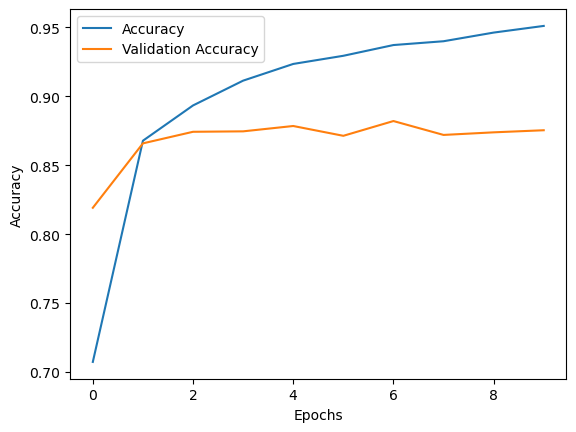

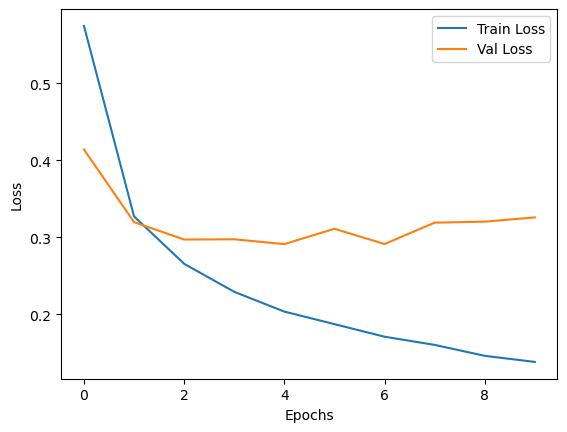

In [25]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Observation:

The model learns very quickly, with training accuracy rising steeply. However, validation accuracy soon plateaus and validation loss begins to rise, indicating overfitting.

### Evaluating with Tensor board

Evaluating our model’s performance involves measuring accuracy and loss. However, in sentiment analysis, other metrics like precision, recall, and F1-score may also be helpful.

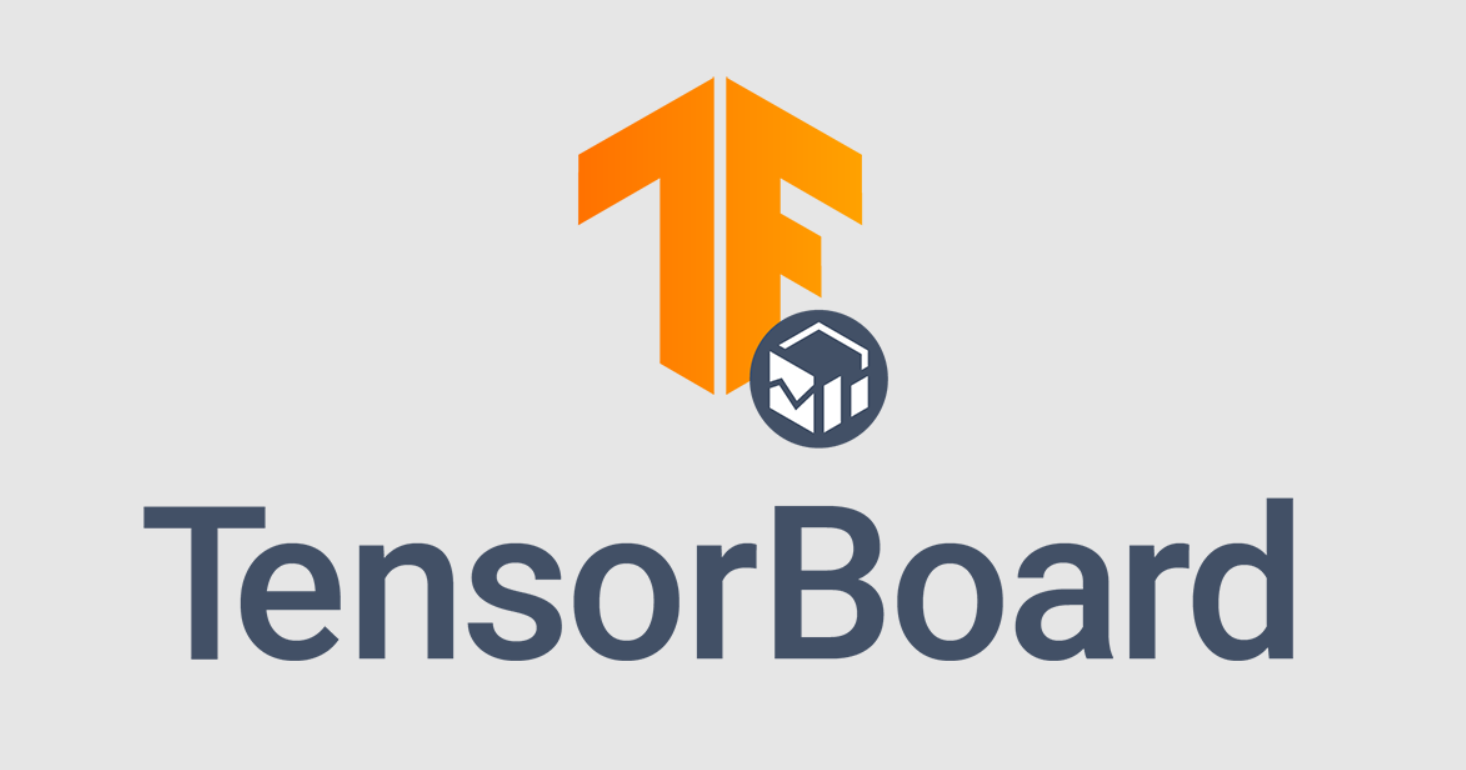

- TensorBoard is an incredibly useful tool that allows you to visualize key metrics during model training, making it easier to understand how well your model is performing. It shows real-time graphs of metrics like loss and accuracy, which help you spot issues like overfitting—where the model performs well on training data but poorly on unseen data. By tracking these metrics visually, you can quickly identify problems and make adjustments, such as tweaking hyperparameters or adding regularization techniques like dropout. Essentially, TensorBoard gives you a clear, interactive view of your model’s training progress, making it easier to diagnose and improve performance.

In [21]:
# Log training progress for TensorBoard (saved in ./logs directory)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

# Train the already-compiled model:
# - Uses the optimizer, loss function, and metrics defined earlier in model.compile()
# - Runs for 10 epochs
# - Validates on the test set after each epoch
# - Logs metrics to TensorBoard for visualization
model.fit(
    train_data, train_labels,
    epochs=10,
    validation_data=(test_data, test_labels),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9552 - loss: 0.1282 - val_accuracy: 0.8698 - val_loss: 0.3444
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9558 - loss: 0.1249 - val_accuracy: 0.8710 - val_loss: 0.3499
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9584 - loss: 0.1196 - val_accuracy: 0.8681 - val_loss: 0.3717
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9647 - loss: 0.1066 - val_accuracy: 0.8580 - val_loss: 0.4102
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9666 - loss: 0.1008 - val_accuracy: 0.8674 - val_loss: 0.3915
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9675 - loss: 0.0973 - val_accuracy: 0.8626 - val_loss: 0.4276
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9692 - loss: 0.0926 - val_accuracy: 0.8591 - val_loss: 0.4284
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9719 - loss: 0.0887 - val_accuracy: 0.

- Here, we set up TensorBoard to visualize the model's training process by using the `TensorBoard` callback. This callback logs the training details to a specified directory (`log_dir="./logs"`), which can be accessed later for visualization. We then trained the model for 10 epochs, with validation data passed in for monitoring the model’s performance on unseen data. By adding the `tensorboard_callback` to the `callbacks` list, we enabled logging of various metrics (such as loss and accuracy) during training. This allows us to track the model’s progress in real time and provides detailed visualizations through TensorBoard, helping us understand the model's learning behavior and performance throughout the training process.

In Google Colab, launch TensorBoard with:

In [23]:
# Load the TensorBoard extension into the notebook
%load_ext tensorboard

# Launch TensorBoard inside the notebook
# - Reads training logs from the "logs" directory (created by the callback)
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4430), started 0:05:05 ago. (Use '!kill 4430' to kill it.)

## LSTM Model

After preparing the data and building a baseline model with an Embedding + Dense layer, I evaluated its performance. While this model was effective in capturing semantic relationships between words, it did not account for word order or long-term dependencies in the text.

To address this, I extended the architecture by replacing the Dense layer with an LSTM layer. LSTMs are designed to remember sequential patterns and context over time, making them well-suited for text data. With this change, the model could better capture the flow of sentences, leading to improved results compared to the baseline.

In [26]:
# Define an LSTM-based model
lstm_model = keras.Sequential([
    keras.layers.Embedding(10000, 128),   # Converts word indices (0–9999) into 128-dim dense vectors
    keras.layers.LSTM(64),                # LSTM layer with 64 memory units for sequence learning
    keras.layers.Dense(1, activation="sigmoid")  # Output layer for binary classification
])

# Compile the model
lstm_model.compile(
    optimizer="adam", 
    loss="binary_crossentropy",           # Loss for binary classification
    metrics=["accuracy"]                  # Track accuracy during training
)

# Train the model
history2 = lstm_model.fit(
    train_data, train_labels, 
    epochs=5,                             # Train for 5 passes over the dataset
    validation_data=(test_data, test_labels)  # Validate on test set after each epoch
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - accuracy: 0.5556 - loss: 0.6652 - val_accuracy: 0.6537 - val_loss: 0.6195
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 85ms/step - accuracy: 0.6959 - loss: 0.5401 - val_accuracy: 0.8118 - val_loss: 0.4311
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.8887 - loss: 0.2835 - val_accuracy: 0.8730 - val_loss: 0.3037
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 78s 99ms/step - accuracy: 0.9330 - loss: 0.1871 - val_accuracy: 0.8773 - val_loss: 0.3195
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.9550 - loss: 0.1322 - val_accuracy: 0.8727 - val_loss: 0.3427


### Model Evaluation
Visualizing Training Progress

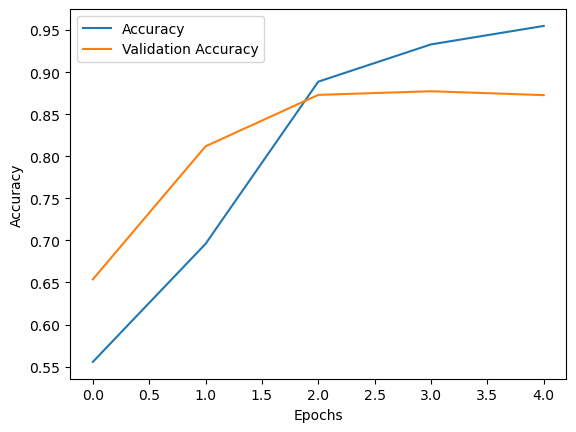

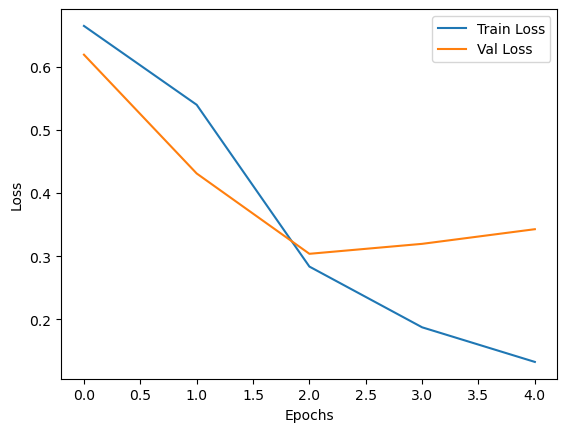

In [27]:
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Observations:

**Dense baseline:** The model learns very quickly, with training accuracy rising steeply. However, validation accuracy soon plateaus and validation loss begins to rise, indicating classic overfitting.

**LSTM model:** Training progresses more slowly, but validation accuracy reaches a higher level and validation loss remains lower. This suggests that the LSTM is able to generalize better by capturing word order and context, although it comes at the cost of slower training.

## Hugging Face and Transformer-Based Models

Pretrained transformer models, such as BERT, excel at text classification tasks due to their attention mechanisms and large-scale pretraining.

### Using BERT for Sentiment Analysis

With Hugging Face’s library, we can leverage BERT’s pretrained knowledge.

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

sample_text = ["I loved this movie!"]
inputs = tokenizer(sample_text, return_tensors="tf", padding=True, truncation=True, max_length=256)
output = model(inputs)
print("Logits:", output.logits)

- Here, we utilized the BERT model from the Hugging Face `transformers` library to perform sequence classification. First, we loaded the **BertTokenizer** and **TFBertForSequenceClassification** using the pre-trained `"bert-base-uncased"` model. We then tokenized a sample review (`"I loved this movie!"`) using the tokenizer, which converts the text into tokens, padding or truncating the sequence to a maximum length of 256. The tokenized input is passed to the BERT model, which generates the model's output logits—raw values representing the model's predictions for each class. Finally, we printed the logits, which are used to calculate the final classification results, such as determining if the review is positive or negative. This approach leverages BERT's powerful contextual understanding to improve the accuracy of sentiment classification tasks.